In [181]:
# Cell 1
# Import libraries
import pandas as pd
import numpy as np
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Ensure NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/PremGanesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/PremGanesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [182]:
# Cell 2
# Load your Excel files for training and validation
train_file_path = '/Users/PremGanesh/Developer/AI/CyVidia/Input_Data/Training Dataset.xlsx'
# load the excel file as a dataframe
train_df = pd.read_excel(train_file_path) 
print(train_df.shape) # print the shape of the dataframe
model_name = 'trained_model_rbi_jll_nist_scf'
requirment_area = 'Requirement Area (NIST)'
requirment_bucket = 'Requirement Bucket(NIST)'


(2104, 3)


In [183]:
# Cell 3
# Define a function for text cleaning
def clean_text(text):
    if isinstance(text, float) and np.isnan(text): # check if the text is NaN
        return "" # return empty string
    words = word_tokenize(text) # tokenize the text into words using NLTK library 
    words = [word.lower() for word in words if word.isalnum()] # convert all words to lower case and remove punctuations    
    stop_words = set(stopwords.words('english')) # get the stop words from NLTK library 
    words = [word for word in words if word not in stop_words] # remove stop words from the text
    clean_text = ' '.join(words) # join all words into a sentence
    return clean_text # return the cleaned text


In [184]:
# Cell 4
# Apply text cleaning to 'Requirement Description' column for training and validation data
train_df['Cleaned_Description'] = train_df['Requirement Description'].apply(clean_text)

In [185]:
# Cell 5
# Tokenize and pad sequences for training data
max_words = 10000 # We will only consider the top 1000 words in the dataset i want to use the complete dataset
tokenizer = Tokenizer(num_words=max_words) # Setup tokenizer using keras Tokenizer class 
tokenizer.fit_on_texts(train_df['Cleaned_Description']) # fit tokenizer on training data
X_train = tokenizer.texts_to_sequences(train_df['Cleaned_Description']) # convert text to sequence of tokens
X_train = pad_sequences(X_train, maxlen=100) # pad sequences to make them of equal length
print(X_train.shape) # print shape of training data

(2104, 100)


In [186]:

# Cell 6
# Label encode 'Requirement Area' for training data
area_encoder = LabelEncoder()
train_df[requirment_area] = train_df[requirment_area].str.lower()
y_area_train = area_encoder.fit_transform(train_df[requirment_area])


In [187]:
# Cell 7
# Label encode requirment_bucket for training data
bucket_encoder = LabelEncoder()
train_df[requirment_bucket] = train_df[requirment_bucket].str.lower()
y_bucket_train = bucket_encoder.fit_transform(train_df[requirment_bucket])

In [188]:
# Cell 8
model_file_path = model_name

In [189]:
# # Cell 9
# # Check if the model file exists and load it, or create a new model
# if os.path.exists(model_file_path):
#     model = tf.keras.models.load_model(model_file_path)
# else:
#     model = Sequential()
#     model.add(Embedding(input_dim=max_words, output_dim=128, input_length=100))
#     model.add(LSTM(128)) # what  is 128 here? 
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
#     output_area = Dense(len(area_encoder.classes_), activation='softmax', name='output_area')(model.layers[-1].output)
#     output_bucket = Dense(len(bucket_encoder.classes_), activation='softmax', name='output_bucket')(model.layers[-1].output)
#     model = Model(inputs=model.input, outputs=[output_area, output_bucket])
#     model.compile(
#         loss={'output_area': 'sparse_categorical_crossentropy', 'output_bucket': 'sparse_categorical_crossentropy'},
#         optimizer='adam',
#         metrics={'output_area': 'accuracy', 'output_bucket': 'accuracy'}
#     )
# # Cell 9 - Model definition
# model = Sequential()
# model.add(Embedding(input_dim=max_words, output_dim=64, input_length=100))  # Reduced output_dim
# model.add(LSTM(64, return_sequences=True))  # Reduced LSTM units, added return_sequences for stacking
# model.add(Dropout(0.3))  # Added dropout
# model.add(LSTM(32))  # Added another LSTM layer with reduced units
# model.add(Dropout(0.3))  # Added dropout
# model.add(Dense(32, activation='relu'))  # Reduced Dense units
# model.add(Dropout(0.3))  # Added dropout
# output_area = Dense(len(area_encoder.classes_), activation='softmax', name='output_area')(model.output)
# output_bucket = Dense(len(bucket_encoder.classes_), activation='softmax', name='output_bucket')(model.output)
# model = Model(inputs=model.input, outputs=[output_area, output_bucket])
# model.compile(loss={'output_area': 'sparse_categorical_crossentropy', 'output_bucket': 'sparse_categorical_crossentropy'},
#               optimizer='adam', metrics={'output_area': 'accuracy', 'output_bucket': 'accuracy'})
# Cell 9 - Model definition
if os.path.exists(model_file_path):
    model = tf.keras.models.load_model(model_file_path)
else:
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=64, input_length=100))  # Reduced output_dim
    model.add(LSTM(64, return_sequences=True))  # Reduced LSTM units, added return_sequences for stacking
    model.add(Dropout(0.3))  # Added dropout
    model.add(LSTM(32))  # Added another LSTM layer with reduced units
    model.add(Dropout(0.3))  # Added dropout
    model.add(Dense(32, activation='relu'))  # Reduced Dense units
    model.add(Dropout(0.3))  # Added dropout
    output_area = Dense(len(area_encoder.classes_), activation='softmax', name='output_area')(model.output)
    output_bucket = Dense(len(bucket_encoder.classes_), activation='softmax', name='output_bucket')(model.output)
    model = Model(inputs=model.input, outputs=[output_area, output_bucket])
    model.compile(loss={'output_area': 'sparse_categorical_crossentropy', 'output_bucket': 'sparse_categorical_crossentropy'},
                optimizer='adam', metrics={'output_area': 'accuracy', 'output_bucket': 'accuracy'})



In [190]:
# # Cell 10
# # Train the model on training data with both labels and store the training history
# history = model.fit(X_train, {'output_area': y_area_train, 'output_bucket': y_bucket_train}, epochs=100, batch_size=32)
# Cell 10 - Training the model with EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# history = model.fit(X_train, {'output_area': y_area_train, 'output_bucket': y_bucket_train},
#                     epochs=100, batch_size=32, 
#                     validation_split=0.2,  # 20% of data used for validation
#                     callbacks=[early_stopping])
from tensorflow.keras.callbacks import ModelCheckpoint

# Cell 10 - Training the model with EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Assuming you have a validation set, named X_val, y_area_val, y_bucket_val
history = model.fit(X_train, {'output_area': y_area_train, 'output_bucket': y_bucket_train},
                    validation_data=(X_val, {'output_area': y_area_val, 'output_bucket': y_bucket_val}),
                    epochs=100, batch_size=32, 
                    callbacks=[early_stopping, model_checkpoint])



Epoch 1/100
53/53 [==============================] - 10s 103ms/step - loss: 5.1594 - output_area_loss: 1.1393 - output_bucket_loss: 4.0201 - output_area_accuracy: 0.6506 - output_bucket_accuracy: 0.1367 - val_loss: 10.1108 - val_output_area_loss: 3.7780 - val_output_bucket_loss: 6.3328 - val_output_area_accuracy: 0.1876 - val_output_bucket_accuracy: 0.0238
Epoch 2/100
53/53 [==============================] - 4s 85ms/step - loss: 4.9736 - output_area_loss: 1.0649 - output_bucket_loss: 3.9087 - output_area_accuracy: 0.6750 - output_bucket_accuracy: 0.1420 - val_loss: 10.8412 - val_output_area_loss: 4.1362 - val_output_bucket_loss: 6.7049 - val_output_area_accuracy: 0.1639 - val_output_bucket_accuracy: 0.0214
Epoch 3/100
53/53 [==============================] - 4s 79ms/step - loss: 4.7392 - output_area_loss: 0.9721 - output_bucket_loss: 3.7671 - output_area_accuracy: 0.6875 - output_bucket_accuracy: 0.1515 - val_loss: 11.3162 - val_output_area_loss: 4.2962 - val_output_bucket_loss: 7.0200

In [191]:
# Cell 11
# Save the model to a file in the TensorFlow SavedModel format
model.save(model_file_path)


INFO:tensorflow:Assets written to: trained_model_rbi_jll_nist_scf/assets


INFO:tensorflow:Assets written to: trained_model_rbi_jll_nist_scf/assets


In [192]:

# Cell 12
# Save the tokenizer using pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [193]:



# Cell 13
# Save the encoders using pickle
with open('area_encoder.pickle', 'wb') as handle:
    pickle.dump(area_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('bucket_encoder.pickle', 'wb') as handle:
    pickle.dump(bucket_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)


system and communication protection 254
access control 241
system and services acquisition 216
system and information integrity 186
configuration management 127
identification and authentication 125
incident response 107
audit and accountability 102
contingency planning 100
physical and environmental protection 91
program management 83
supply chain risk management 71
assessment, authorization and monitoring 69
risk assessment 62
maintenance 52
personally identifiable information processing and transparency 51
media protection 47
awareness and training 36
personnel security 31
planning 30
card payments security 20
internet banking 1
credit card process 1
transaction security 1


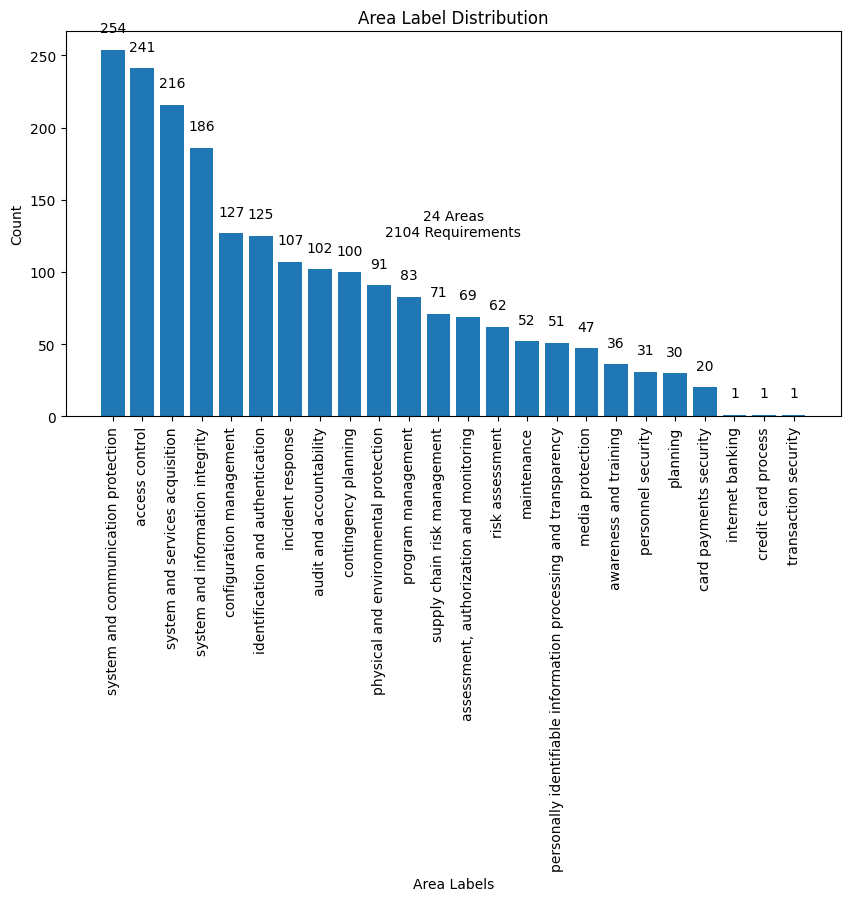

In [194]:
# Visualize label distribution for 'Area'
import matplotlib.pyplot as plt

# Get the sorted area labels and their counts
area_labels, area_counts = zip(*sorted(zip(train_df[requirment_area].value_counts().index, train_df[requirment_area].value_counts()), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.bar(area_labels, area_counts)
plt.xticks(rotation=90)

# add title with the number of areas and the total number of requirements
plt.title('Area Label Distribution')
plt.text(0.5, 0.5, str(len(area_labels)) + ' Areas\n' + str(len(train_df)) + ' Requirements',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('Area Labels')
plt.ylabel('Count')
#PRINT COUNT OF EACH AREA
for i, v in enumerate(area_counts):
    print(area_labels[i], v)
   
# add count values on top of the bars
for i, v in enumerate(area_counts):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')

plt.show()


In [195]:

# # Cell 15
# # Visualize label distribution for 'Bucket'
# plt.figure(figsize=(15, 5))
# #start from 0 to 150
# plt.bar(bucket_encoder.classes_, train_df[requirment_bucket].value_counts())
# #rotate the labels by 90 degrees
# plt.xticks(rotation=90)
# #add title with no.of buckets and total no.of requirements
# plt.title('Bucket Label Distribution')
# plt.text(0.5, 0.5, str(len(bucket_encoder.classes_)) + ' Buckets\n' + str(len(train_df)) + ' Requirements',
#          horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# #label the x and y axis
# plt.xlabel('Bucket Labels')
# plt.ylabel('Count')
# #display the count of each label
# # add count values on top of the bars
# for i, v in enumerate(area_counts):
#     plt.text(i, v + 10, str(v), ha='center', va='bottom')
# # plt.show()
# # print labels in a list 
# # print(bucket_encoder.classes_)

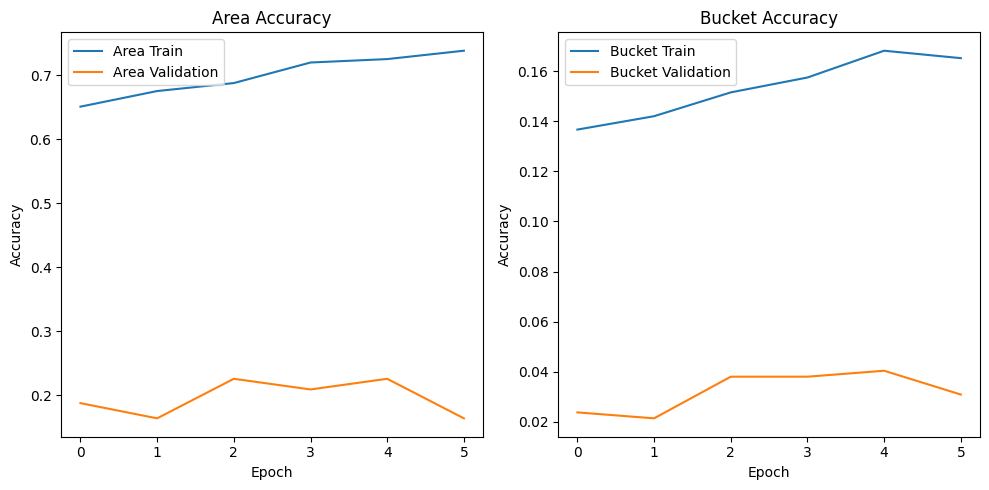

In [196]:
# # Cell 16
# # Visualize training history for 'Area' and 'Bucket'
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['output_area_accuracy'])
# plt.plot(history.history['output_bucket_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Area', 'Bucket'], loc='upper left')
# # add highest accuracy values on top of the lines
# plt.text(len(history.history['output_area_accuracy']) - 1, history.history['output_area_accuracy'][-1],
#          str(round(history.history['output_area_accuracy'][-1], 2)), ha='center', va='bottom')
# plt.show()
# Cell 16 - Visualize training and validation history for 'Area' and 'Bucket'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['output_area_accuracy'], label='Area Train')
plt.plot(history.history['val_output_area_accuracy'], label='Area Validation')
plt.title('Area Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['output_bucket_accuracy'], label='Bucket Train')
plt.plot(history.history['val_output_bucket_accuracy'], label='Bucket Validation')
plt.title('Bucket Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
